In [1]:
%cd /content/drive/MyDrive/My Data Analytics/CMS_ROS01

/content/drive/MyDrive/My Data Analytics/CMS_ROS01


In [2]:
# Importing Librs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [3]:
df = pd.read_csv("carrier01.csv", header=None)  # read everything raw
df.columns = df.iloc[1]   # set column names from 2nd row
df = df.drop([0,1])       # drop first two rows (row 0 = numbers, row 1 = headers already used)
df = df.reset_index(drop=True)

/tmp/ipython-input-18610607.py:1: DtypeWarning: Columns (0,1,3,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,24,26,28,30,32,34,36,38,40,42,44,46,48,49,50,51,52,53,54,55,56,57,59,60,61,62,63,64,65,66,70,71,73,74,75,76,78,79,80,81,83,84,85,86,88,90,91,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("carrier01.csv", header=None)  # read everything raw


In [4]:
df.head(3)

1,BENE_ID,CLM_ID,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLM_FROM_DT,CLM_THRU_DT,NCH_WKLY_PROC_DT,CARR_CLM_ENTRY_CD,CLM_DISP_CD,CARR_NUM,...,CARR_LINE_MTUS_CD,LINE_ICD_DGNS_CD,LINE_ICD_DGNS_VRSN_CD,HPSA_SCRCTY_IND_CD,CARR_LINE_RX_NUM,LINE_HCT_HGB_RSLT_NUM,LINE_HCT_HGB_TYPE_CD,LINE_NDC_CD,CARR_LINE_CLIA_LAB_NUM,CARR_LINE_ANSTHSA_UNIT_CNT
0,-10000010254618,-10000930037915,O,71,28-Sep-2015,28-Sep-2015,02-Oct-2015,1,1,00510,...,NaN,NaN,0,,NaN,0.0,R1,NaN,NaN,0
1,-10000010254618,-10000930037915,O,71,28-Sep-2015,28-Sep-2015,02-Oct-2015,1,1,00510,...,NaN,R4689,0,,NaN,0.0,R1,NaN,NaN,0
2,-10000010254618,-10000930037915,O,71,28-Sep-2015,28-Sep-2015,02-Oct-2015,1,1,00510,...,NaN,D649,0,,NaN,0.0,R1,NaN,NaN,0


In [5]:
print(df.dtypes)

print(df.columns)

1
BENE_ID                       object
CLM_ID                        object
NCH_NEAR_LINE_REC_IDENT_CD    object
NCH_CLM_TYPE_CD               object
CLM_FROM_DT                   object
                               ...  
LINE_HCT_HGB_RSLT_NUM         object
LINE_HCT_HGB_TYPE_CD          object
LINE_NDC_CD                   object
CARR_LINE_CLIA_LAB_NUM        object
CARR_LINE_ANSTHSA_UNIT_CNT    object
Length: 96, dtype: object
Index(['BENE_ID', 'CLM_ID', 'NCH_NEAR_LINE_REC_IDENT_CD', 'NCH_CLM_TYPE_CD',
       'CLM_FROM_DT', 'CLM_THRU_DT', 'NCH_WKLY_PROC_DT', 'CARR_CLM_ENTRY_CD',
       'CLM_DISP_CD', 'CARR_NUM', 'CARR_CLM_PMT_DNL_CD', 'CLM_PMT_AMT',
       'CARR_CLM_PRMRY_PYR_PD_AMT', 'RFR_PHYSN_UPIN', 'RFR_PHYSN_NPI',
       'CARR_CLM_PRVDR_ASGNMT_IND_SW', 'NCH_CLM_PRVDR_PMT_AMT',
       'NCH_CLM_BENE_PMT_AMT', 'NCH_CARR_CLM_SBMTD_CHRG_AMT',
       'NCH_CARR_CLM_ALOWD_AMT', 'CARR_CLM_CASH_DDCTBL_APLD_AMT',
       'CARR_CLM_HCPCS_YR_CD', 'CARR_CLM_RFRNG_PIN_NUM', 'PRNCPAL_DGNS_CD',

# **DATA CLEANING & VAILIDATION**

In [6]:
# Validate uniqueness of (CLM_ID, LINE_NUM)
# Ensures each claim line is represented once.

dup_count = df.duplicated(subset=["CLM_ID", "LINE_NUM"]).sum()
print("Duplicate (CLM_ID, LINE_NUM):", dup_count)

Duplicate (CLM_ID, LINE_NUM): 0


In [7]:
# Mandatory financial columns

financial_cols = [
    "LINE_SBMTD_CHRG_AMT",
    "LINE_ALOWD_CHRG_AMT",
    "LINE_NCH_PMT_AMT",
    "LINE_PRVDR_PMT_AMT"
]

df[financial_cols].isnull().mean() * 100

,0
1,
LINE_SBMTD_CHRG_AMT,0.0
LINE_ALOWD_CHRG_AMT,0.0
LINE_NCH_PMT_AMT,0.0
LINE_PRVDR_PMT_AMT,0.0


In [8]:
# Logical Fin Consistency checks

df["FIN_LOGIC_VIOLATION"] = (
    (df["LINE_SBMTD_CHRG_AMT"] < df["LINE_ALOWD_CHRG_AMT"]) |
    (df["LINE_ALOWD_CHRG_AMT"] < df["LINE_NCH_PMT_AMT"]) |
    (df["LINE_NCH_PMT_AMT"] < df["LINE_PRVDR_PMT_AMT"])
)

df["FIN_LOGIC_VIOLATION"].value_counts(normalize=True) * 100

# % of claim lines logically inconsistent.

,proportion
FIN_LOGIC_VIOLATION,
False,99.858609
True,0.141391


In [9]:
# Inspect Violations

df[df["FIN_LOGIC_VIOLATION"] == True].count()


,0
1,
BENE_ID,1585
CLM_ID,1585
NCH_NEAR_LINE_REC_IDENT_CD,1585
NCH_CLM_TYPE_CD,1585
CLM_FROM_DT,1585
...,...
LINE_HCT_HGB_TYPE_CD,1585
LINE_NDC_CD,0
CARR_LINE_CLIA_LAB_NUM,57


In [10]:
# Convert to datetime

date_cols = ["LINE_1ST_EXPNS_DT", "NCH_WKLY_PROC_DT"]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

In [11]:
# Missing date check

df[date_cols].isnull().mean() * 100

,0
1,
LINE_1ST_EXPNS_DT,0.0
NCH_WKLY_PROC_DT,0.0


In [12]:
# Date Logical consistency checks

df["DATE_LOGIC_VIOLATION"] = (
    df["NCH_WKLY_PROC_DT"] < df["LINE_1ST_EXPNS_DT"]
)

df["DATE_LOGIC_VIOLATION"].value_counts(normalize=True) * 100

,proportion
DATE_LOGIC_VIOLATION,
False,100.0


In [13]:
# Year Check

df["SERVICE_YEAR"] = df["LINE_1ST_EXPNS_DT"].dt.year

print(df["SERVICE_YEAR"])

0          2015
1          2015
2          2015
3          2015
4          2015
           ... 
1120999    2022
1121000    2022
1121001    2022
1121002    2022
1121003    2022
Name: SERVICE_YEAR, Length: 1121004, dtype: int32


In [14]:
# Year 2022 Filtering

df_2022 = df[df["SERVICE_YEAR"] == 2022].copy()

print("Rows after 2022 filter:", df_2022.shape[0])


Rows after 2022 filter: 174645


In [15]:
# HCPCS Code Validation

df_2022["HCPCS_MISSING"] = df_2022["HCPCS_CD"].isnull()

df_2022["HCPCS_MISSING"].value_counts(normalize=True) * 100

,proportion
HCPCS_MISSING,
True,62.242835
False,37.757165


In [16]:
# Check data type of amount columns


# The allowed charge amount — what the payer considers reasonable and eligible for payment.
print(df_2022["LINE_ALOWD_CHRG_AMT"].dtypes)

# The payment amount made under the National Claims History (NCH) system (Medicare/Medicaid context).
print(df_2022["LINE_NCH_PMT_AMT"].dtypes)

# The charge amount submitted by the provider (the “billed” amount).
print(df_2022["LINE_SBMTD_CHRG_AMT"].dtypes)

# The actual payment amount made to the provider for that claim line.
print(df_2022["LINE_PRVDR_PMT_AMT"].dtypes)


object
object
object
object


In [17]:
# Change the dtype to float

df_2022["LINE_ALOWD_CHRG_AMT"] = df_2022["LINE_ALOWD_CHRG_AMT"].astype(float)
df_2022["LINE_NCH_PMT_AMT"] = df_2022["LINE_NCH_PMT_AMT"].astype(float)
df_2022["LINE_SBMTD_CHRG_AMT"] = df_2022["LINE_SBMTD_CHRG_AMT"].astype(float)
df_2022["LINE_PRVDR_PMT_AMT"] = df_2022["LINE_PRVDR_PMT_AMT"].astype(float)

In [18]:
# Save Cleaned Dataset
df_2022.to_csv("carrier_01.csv", index=False)

# **REVENUE REALIZATION & UNDERPAYMENT ANALYSIS**

In [19]:
df_fin = df_2022[df_2022["FIN_LOGIC_VIOLATION"]==False].copy()

print("Rows used for financial analysis:", df_fin.shape[0])
print("Excluded rows (%):",
      round(100 * (1 - len(df_fin) / len(df_2022)), 2))

Rows used for financial analysis: 174411
Excluded rows (%): 0.13


# Calculated Fields

In [20]:
# PROCESSING_DELAY_DAYS

df_fin["PROCESSING_DELAY_DAYS"] = (
    df_fin["NCH_WKLY_PROC_DT"] - df_fin["LINE_1ST_EXPNS_DT"]
).dt.days

df_fin["PROCESSING_DELAY_DAYS"].describe()


,PROCESSING_DELAY_DAYS
count,174411.000000
mean,4.000631
std,2.013469
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,8.000000


In [21]:
# Delay Validation

df_fin["VALID_DELAY"] = (
    df_fin["PROCESSING_DELAY_DAYS"].notnull() &
    (df_fin["PROCESSING_DELAY_DAYS"] >= 0)
)

In [22]:
# UNDERPAYMENT

df_fin["UNDERPAYMENT_AMT"] = (
    df_fin["LINE_ALOWD_CHRG_AMT"] - df_fin["LINE_NCH_PMT_AMT"]
)

df_fin["UNDERPAYMENT_AMT"].describe()


,UNDERPAYMENT_AMT
count,174411.000000
mean,31.417920
std,203.018016
min,0.000000
25%,0.000000
50%,0.000000
75%,23.750000
max,17187.580000


In [23]:
# REALIZATION_RATE: How much of the billed charges are ultimately realised as cash.
# A critical KPI for understanding revenue efficiency.

df_fin["REALIZATION_RATE"] = (
    df_fin["LINE_NCH_PMT_AMT"] / df_fin["LINE_ALOWD_CHRG_AMT"]
)

df_fin["REALIZATION_RATE"].describe()


,REALIZATION_RATE
count,73889.000000
mean,0.747683
std,0.248713
min,0.000000
25%,0.799969
50%,0.800000
75%,0.800016
max,1.000000


In [24]:
# Payment-to-Submitted Ratio or Gross-to-Net Ratio:
# How much of the billed amount the provider actually receives.

df_fin["Gross-to-Net Ratio"] = (
    df_fin["LINE_PRVDR_PMT_AMT"] / df_fin["LINE_SBMTD_CHRG_AMT"])

df_fin["Gross-to-Net Ratio"].describe()


,Gross-to-Net Ratio
count,73889.000000
mean,0.747683
std,0.248713
min,0.000000
25%,0.799969
50%,0.800000
75%,0.800016
max,1.000000


In [25]:
# Payment-to-Allowed Ratio: Efficiency of reimbursement relative to what was allowed.

df_fin["Payment_to_Allowed_Ratio"] = (
    df_fin["LINE_NCH_PMT_AMT"] / df_fin["LINE_ALOWD_CHRG_AMT"])

df_fin["Payment_to_Allowed_Ratio"].describe()


,Payment_to_Allowed_Ratio
count,73889.000000
mean,0.747683
std,0.248713
min,0.000000
25%,0.799969
50%,0.800000
75%,0.800016
max,1.000000


In [26]:
# Discount Rate: Average reduction applied by payers to billed charges.

df_fin["Discount_Rate"] = (1-(
    df_fin["LINE_ALOWD_CHRG_AMT"] / df_fin["LINE_SBMTD_CHRG_AMT"]))

df_fin["Discount_Rate"].describe()


,Discount_Rate
count,73889.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [27]:
# Denial/Adjustment Rate: Proportion of allowed charges not actually paid.

df_fin["Denial_Rate"] = (1 - (
    df_fin["LINE_NCH_PMT_AMT"] / df_fin["LINE_ALOWD_CHRG_AMT"]))

df_fin["Denial_Rate"].describe()


,Denial_Rate
count,73889.000000
mean,0.252317
std,0.248713
min,0.000000
25%,0.199984
50%,0.200000
75%,0.200031
max,1.000000


In [28]:
# Provider Net Collection Rate or  Collection Effectiveness Index or Reimbursement Efficiency:
# Measures how effectively providers collect what payers allow.

df_fin["Net_Collection_Rate"] = (
    df_fin["LINE_PRVDR_PMT_AMT"] / df_fin["LINE_ALOWD_CHRG_AMT"])

df_fin["Net_Collection_Rate"].describe()


,Net_Collection_Rate
count,73889.000000
mean,0.747683
std,0.248713
min,0.000000
25%,0.799969
50%,0.800000
75%,0.800016
max,1.000000


In [29]:
# Overall Revenue Baseline

overall_summary = pd.DataFrame({
    "Metric": [
        "Total Submitted Charges",
        "Total Allowed Amount",
        "Total Payer (NCH) Paid Amount",
        "Total Actual Paid Amount",
        "Total Underpayment",
        "Overall Revenue Realization (%)",
        "Toatl PROCESSING DELAY DAYS",
        "Gross-to-Net Ratio",
        "Payment-to-Allowed_Ratio",
        "Net Collection_Rate",
        "Discount Rate",
        "Denial Rate"
    ],
    "Value": [
        df_fin["LINE_SBMTD_CHRG_AMT"].sum(),
        df_fin["LINE_ALOWD_CHRG_AMT"].sum(),
        df_fin["LINE_NCH_PMT_AMT"].sum(),
        df_fin["LINE_PRVDR_PMT_AMT"].sum(),
        df_fin["UNDERPAYMENT_AMT"].sum(),
        100 * df_fin["LINE_NCH_PMT_AMT"].sum() / df_fin["LINE_ALOWD_CHRG_AMT"].sum(),
        df_fin["PROCESSING_DELAY_DAYS"].sum(),
        100 * df_fin["LINE_PRVDR_PMT_AMT"].sum() / df_fin["LINE_SBMTD_CHRG_AMT"].sum(),
        100 * df_fin["LINE_NCH_PMT_AMT"].sum() / df_fin["LINE_ALOWD_CHRG_AMT"].sum(),
        100 * df_fin["LINE_PRVDR_PMT_AMT"].sum() / df_fin["LINE_ALOWD_CHRG_AMT"].sum(),
        100 * (1 - (df_fin["LINE_ALOWD_CHRG_AMT"].sum() / df_fin["LINE_SBMTD_CHRG_AMT"].sum())),
        100 * (1 - (df_fin["LINE_NCH_PMT_AMT"].sum() / df_fin["LINE_ALOWD_CHRG_AMT"].sum()))
    ]
})

print(overall_summary)


                             Metric         Value
0           Total Submitted Charges  2.468042e+07
1              Total Allowed Amount  2.468042e+07
2     Total Payer (NCH) Paid Amount  1.920079e+07
3          Total Actual Paid Amount  1.920079e+07
4                Total Underpayment  5.479631e+06
5   Overall Revenue Realization (%)  7.779766e+01
6       Toatl PROCESSING DELAY DAYS  6.977540e+05
7                Gross-to-Net Ratio  7.779766e+01
8          Payment-to-Allowed_Ratio  7.779766e+01
9               Net Collection_Rate  7.779766e+01
10                    Discount Rate  0.000000e+00
11                      Denial Rate  2.220234e+01


HCPCS WISE

In [30]:
# Aggregate by HCPCS

hcpcs_summary = (
    df_fin
    .groupby("HCPCS_CD", as_index=False)
    .agg(
        services=("LINE_NUM", "count"),
        allowed_amt=("LINE_ALOWD_CHRG_AMT", "sum"),
        paid_amt=("LINE_NCH_PMT_AMT", "sum"),
        underpayment_amt=("UNDERPAYMENT_AMT", "sum"),
        processing_delays=("PROCESSING_DELAY_DAYS", "sum")

    )
)

hcpcs_summary["realization_rate"] = (
    hcpcs_summary["paid_amt"] / hcpcs_summary["allowed_amt"])
hcpcs_summary["denial_rate"] = (
    1 - hcpcs_summary["realization_rate"])


In [31]:
# Rank Leakage Drivers

hcpcs_summary = hcpcs_summary.sort_values(
    by="underpayment_amt", ascending=False
)

hcpcs_summary.head(5)

,HCPCS_CD,services,allowed_amt,paid_amt,underpayment_amt,processing_delays,realization_rate,denial_rate
6,96156,11142,5654283.70,4479713.77,1174569.93,44496,0.792269,0.207731
4,94010,582,5354937.86,4237977.95,1116959.91,2397,0.791415,0.208585
9,99495,6373,3754660.46,2966992.60,787667.86,25423,0.790216,0.209784
23,G8839,1346,687741.76,545030.68,142711.08,5313,0.792493,0.207507
35,S9473,164,366567.60,286992.14,79575.46,673,0.782917,0.217083


In [32]:
# Rank denial Drivers

hcpcs_summary = hcpcs_summary.sort_values(
    by="denial_rate", ascending=False
)

hcpcs_summary.head(5)

,HCPCS_CD,services,allowed_amt,paid_amt,underpayment_amt,processing_delays,realization_rate,denial_rate
24,G8939,3,1698.05,878.04,820.01,16,0.517087,0.482913
21,G8434,3,1698.05,1093.18,604.87,7,0.643786,0.356214
32,QS,11,6036.95,4200.70,1836.25,57,0.695832,0.304168
30,I3C,42,47755.62,36688.80,11066.82,168,0.768261,0.231739
33,S0605,34,35545.53,27414.19,8131.34,138,0.771242,0.228758


# **Pareto Analysis**

In [33]:
# (80–20 Logic)

# Sort by underpayment amount (largest first)
hcpcs_summary = hcpcs_summary.sort_values(
    by="underpayment_amt", ascending=False
)


hcpcs_summary["cum_underpayment"] = (
    hcpcs_summary["underpayment_amt"].cumsum()
)

total_underpayment = hcpcs_summary["underpayment_amt"].sum()

hcpcs_summary["cum_underpayment_pct"] = (
    hcpcs_summary["cum_underpayment"] / total_underpayment
)

hcpcs_summary[hcpcs_summary["cum_underpayment_pct"] <= 0.8].head(5)


,HCPCS_CD,services,allowed_amt,paid_amt,underpayment_amt,processing_delays,realization_rate,denial_rate,cum_underpayment,cum_underpayment_pct
6,96156,11142,5654283.70,4479713.77,1174569.93,44496,0.792269,0.207731,1174569.93,0.325653
4,94010,582,5354937.86,4237977.95,1116959.91,2397,0.791415,0.208585,2291529.84,0.635333


- This shows a classic Pareto effect: just two codes are responsible for nearly two‑thirds of all underpayment.

- Both codes have similar realization rates (~79%) and denial rates (~21%), suggesting systemic issues rather than isolated anomalies.

- Processing delays differ sharply: 96156 has very high delays (44,496 days across claims), while 94010 is relatively low (2,397 days). This could hint at workflow bottlenecks for behavioral health services.




In [34]:
# Underpayment Severity Distribution

df_fin["UNDERPAYMENT_PCT"] = (
    df_fin["UNDERPAYMENT_AMT"] / df_fin["LINE_ALOWD_CHRG_AMT"]
)

df_fin["UNDERPAYMENT_PCT"].describe(percentiles=[0.25, 0.5, 0.75, 0.9])

# PCT = Proportion of allowed charges

,UNDERPAYMENT_PCT
count,73889.000000
mean,0.252317
std,0.248713
min,0.000000
25%,0.199984
50%,0.200000
75%,0.200031
90%,0.577382
max,1.000000


In [35]:
# Specialty-Level Revenue Realization

specialty_summary = (
    df_fin
    .groupby("PRVDR_SPCLTY", as_index=False)
    .agg(
        allowed_amt=("LINE_ALOWD_CHRG_AMT", "sum"),
        paid_amt=("LINE_NCH_PMT_AMT", "sum"),
        underpayment_amt=("UNDERPAYMENT_AMT", "sum"),
        processing_delays=("PROCESSING_DELAY_DAYS", "sum")
    )
)

specialty_summary["realization_rate"] = (
    specialty_summary["paid_amt"] / specialty_summary["allowed_amt"]
)

specialty_summary["denial_rate"] = (
    1 - specialty_summary["realization_rate"]
)


specialty_summary.sort_values(
    by="underpayment_amt", ascending=False
).head(10)


,PRVDR_SPCLTY,allowed_amt,paid_amt,underpayment_amt,processing_delays,realization_rate,denial_rate
0,1,24582331.78,19126404.53,5455927.25,693711,0.778055,0.221945
1,01,98092.65,74389.07,23703.58,4043,0.758355,0.241645


In [36]:
# Flag High-Risk Services
#  thresholds (adjust later)

hcpcs_summary["HIGH_LEAKAGE_FLAG"] = (
    (hcpcs_summary["underpayment_amt"] > hcpcs_summary["underpayment_amt"].quantile(0.9)) |
    (hcpcs_summary["realization_rate"] < 0.9)

)

hcpcs_summary[hcpcs_summary["HIGH_LEAKAGE_FLAG"]].head()

,HCPCS_CD,services,allowed_amt,paid_amt,underpayment_amt,processing_delays,realization_rate,denial_rate,cum_underpayment,cum_underpayment_pct,HIGH_LEAKAGE_FLAG
6,96156,11142,5654283.70,4479713.77,1174569.93,44496,0.792269,0.207731,1174569.93,0.325653,True
4,94010,582,5354937.86,4237977.95,1116959.91,2397,0.791415,0.208585,2291529.84,0.635333,True
9,99495,6373,3754660.46,2966992.60,787667.86,25423,0.790216,0.209784,3079197.70,0.853717,True
23,G8839,1346,687741.76,545030.68,142711.08,5313,0.792493,0.207507,3221908.78,0.893284,True
35,S9473,164,366567.60,286992.14,79575.46,673,0.782917,0.217083,3301484.24,0.915346,True


In [37]:
# Outputs

hcpcs_summary.to_csv("hcpcs_underpayment_summary.csv", index=False)
specialty_summary.to_csv("specialty_realization_summary.csv", index=False)


# **ZERO-PAID & PARTIAL-PAID ANALYSIS**


Payment Outcome Categories (CRITICAL)

We classify each claim line into one of three mutually exclusive outcomes.

Definitions (ROS-safe)
*    Category	             |   Logic	Interpretation

*   Zero-Paid	Paid = 0	Denial / non-payment proxy
*   Partial-Paid	0 < Paid < Allowed	Reduction / adjustment
*   Fully-Paid	Paid ≈ Allowed	Normal processing

In [38]:
# Create Payment Flags

df_fin["ZERO_PAID_FLAG"] = df_fin["LINE_NCH_PMT_AMT"] == 0

df_fin["PARTIAL_PAID_FLAG"] = (
    (df_fin["LINE_NCH_PMT_AMT"] > 0) &
    (df_fin["LINE_NCH_PMT_AMT"] < df_fin["LINE_ALOWD_CHRG_AMT"])
)

df_fin["FULLY_PAID_FLAG"] = (
    np.isclose(
        df_fin["LINE_NCH_PMT_AMT"],
        df_fin["LINE_ALOWD_CHRG_AMT"],
        atol=1          # handles rounding differences safely
    )
)

In [39]:
# Overall Denial Proxy Summary

overall_denial_summary = pd.DataFrame({
    "Metric": [
        "Total Claim Lines",
        "Zero-Paid Lines (%)",
        "Partial-Paid Lines (%)",
        "Fully-Paid Lines (%)"
    ],
    "Value": [
        len(df),
        100 *  df_fin["ZERO_PAID_FLAG"].mean(),
        100 *  df_fin["PARTIAL_PAID_FLAG"].mean(),
        100 *  df_fin["FULLY_PAID_FLAG"].mean()
    ]
})

print(overall_denial_summary)

                   Metric         Value
0       Total Claim Lines  1.121004e+06
1     Zero-Paid Lines (%)  6.100819e+01
2  Partial-Paid Lines (%)  3.335512e+01
3    Fully-Paid Lines (%)  6.327181e+01


In [40]:
# Aggregate by HCPCS

hcpcs_denial = (
    df_fin
    .groupby("HCPCS_CD", as_index=False)
    .agg(
        total_lines=("LINE_NUM", "count"),
        zero_paid_lines=("ZERO_PAID_FLAG", "sum"),
        partial_paid_lines=("PARTIAL_PAID_FLAG", "sum"),
        allowed_amt=("LINE_ALOWD_CHRG_AMT", "sum"),
        paid_amt=("LINE_NCH_PMT_AMT", "sum")
    )
)

hcpcs_denial["zero_paid_rate"] = (
    hcpcs_denial["zero_paid_lines"] / hcpcs_denial["total_lines"]
)

hcpcs_denial["partial_paid_rate"] = (
    hcpcs_denial["partial_paid_lines"] / hcpcs_denial["total_lines"]
)

hcpcs_denial["realization_rate"] = (
    hcpcs_denial["paid_amt"] / hcpcs_denial["allowed_amt"]
)

In [41]:
# Identify High-Risk Services

hcpcs_denial = hcpcs_denial.sort_values(
    by=["zero_paid_rate", "partial_paid_rate"],
    ascending=False
)

hcpcs_denial.head(5)

,HCPCS_CD,total_lines,zero_paid_lines,partial_paid_lines,allowed_amt,paid_amt,zero_paid_rate,partial_paid_rate,realization_rate
7,99401,3337,3337,0,0.00,0.00,1.000000,0.000000,NaN
18,G0442,3368,3368,0,0.00,0.00,1.000000,0.000000,NaN
27,G9572,323,323,0,0.00,0.00,1.000000,0.000000,NaN
28,G9573,328,328,0,0.00,0.00,1.000000,0.000000,NaN
8,99408,10058,10053,5,2551.55,2041.24,0.999503,0.000497,0.8


In [42]:
# Contribution of Zero-Paid vs Partial-Paid to Underpayment

df_fin["UNDERPAYMENT_AMT"] = (
    df_fin["LINE_ALOWD_CHRG_AMT"] - df_fin["LINE_NCH_PMT_AMT"]
)

zero_paid_leakage = df_fin.loc[df_fin["ZERO_PAID_FLAG"], "UNDERPAYMENT_AMT"].sum()
partial_paid_leakage = df_fin.loc[df_fin["PARTIAL_PAID_FLAG"], "UNDERPAYMENT_AMT"].sum()
total_leakage = df_fin["UNDERPAYMENT_AMT"].sum()

leakage_breakdown = pd.DataFrame({
    "Category": ["Zero-Paid", "Partial-Paid"],
    "Underpayment Amount": [zero_paid_leakage, partial_paid_leakage],
    "Share of Total Leakage (%)": [
        100 * zero_paid_leakage / total_leakage,
        100 * partial_paid_leakage / total_leakage
    ]
})

print(leakage_breakdown)

       Category  Underpayment Amount  Share of Total Leakage (%)
0     Zero-Paid           1367558.23                   24.957123
1  Partial-Paid           4112072.60                   75.042877


In [43]:
# Specialty-Level Denial Proxy (Operational Lens)

specialty_denial = (
    df_fin
    .groupby("PRVDR_SPCLTY", as_index=False)
    .agg(
        total_lines=("LINE_NUM", "count"),
        zero_paid_rate=("ZERO_PAID_FLAG", "mean"),
        partial_paid_rate=("PARTIAL_PAID_FLAG", "mean")
    )
)

specialty_denial["zero_paid_rate"] *= 100
specialty_denial["partial_paid_rate"] *= 100

specialty_denial.sort_values(
    by="zero_paid_rate", ascending=False
).head(5)


,PRVDR_SPCLTY,total_lines,zero_paid_rate,partial_paid_rate
1,01,975,74.871795,20.923077
0,1,173436,60.930257,33.425010


In [44]:
# High Denial Flags

hcpcs_denial["HIGH_DENIAL_RISK_FLAG"] = (
    (hcpcs_denial["zero_paid_rate"] > hcpcs_denial["zero_paid_rate"].quantile(0.9)) |
    (hcpcs_denial["partial_paid_rate"] > hcpcs_denial["partial_paid_rate"].quantile(0.9))
)

In [45]:
# Save STEP C3 Outputs

hcpcs_denial.to_csv("hcpcs_denial_proxy_summary.csv", index=False)
specialty_denial.to_csv("specialty_denial_proxy_summary.csv", index=False)
leakage_breakdown.to_csv("leakage_breakdown.csv", index=False)

# **DELAY & AR PROXY ANALYSIS**

In [46]:
# Use only rows valid for delay analysis
df_delay = df_fin[df_fin["VALID_DELAY"]].copy()

print("Rows eligible for delay analysis:", df_delay.shape[0])

Rows eligible for delay analysis: 174411


In [47]:
# Define Processing Delay (AR Proxy)
df_delay["PROCESSING_DELAY_DAYS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,PROCESSING_DELAY_DAYS
count,174411.000000
mean,4.000631
std,2.013469
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
90%,7.000000
95%,7.000000
max,8.000000


In [48]:
# Create AR Buckets

bins = [-1, 30, 60, 90, 180, np.inf]
labels = ["0–30", "31–60", "61–90", "91–180", ">180"]

df_delay["AR_BUCKET"] = pd.cut(
    df_delay["PROCESSING_DELAY_DAYS"],
    bins=bins,
    labels=labels
)

df_delay["AR_BUCKET"].value_counts(normalize=True) * 100

,proportion
AR_BUCKET,
0–30,100.0
31–60,0.0
61–90,0.0
91–180,0.0
>180,0.0


In [49]:
# Overall AR Profile

overall_ar_summary = (
    df_delay
    .groupby("AR_BUCKET", as_index=False)
    .agg(
        claim_lines=("LINE_NUM", "count"),
        allowed_amt=("LINE_ALOWD_CHRG_AMT", "sum"),
        paid_amt=("LINE_NCH_PMT_AMT", "sum")
    )
)

overall_ar_summary["revenue_share_pct"] = (
    overall_ar_summary["allowed_amt"] /
    overall_ar_summary["allowed_amt"].sum() * 100
)

print(overall_ar_summary)

  AR_BUCKET  claim_lines  allowed_amt    paid_amt  revenue_share_pct
0      0–30       174411  24680424.43  19200793.6              100.0
1     31–60            0         0.00         0.0                0.0
2     61–90            0         0.00         0.0                0.0
3    91–180            0         0.00         0.0                0.0
4      >180            0         0.00         0.0                0.0


/tmp/ipython-input-745960301.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("AR_BUCKET", as_index=False)


In [50]:
# Aggregate delay by service

hcpcs_delay = (
    df_delay
    .groupby("HCPCS_CD", as_index=False)
    .agg(
        lines=("LINE_NUM", "count"),
        avg_delay_days=("PROCESSING_DELAY_DAYS", "mean"),
        median_delay_days=("PROCESSING_DELAY_DAYS", "median"),
        p90_delay_days=("PROCESSING_DELAY_DAYS", lambda x: x.quantile(0.9)),
        allowed_amt=("LINE_ALOWD_CHRG_AMT", "sum")
    )
)

In [51]:
# Identify slow-moving services
hcpcs_delay = hcpcs_delay.sort_values(
    by="median_delay_days", ascending=False
)

hcpcs_delay.head(5)

,HCPCS_CD,lines,avg_delay_days,median_delay_days,p90_delay_days,allowed_amt
22,G8440,1,7.000000,7.0,7.0,584.00
26,G9530,1,7.000000,7.0,7.0,472.90
25,G8942,4,6.750000,6.5,7.7,2056.85
20,G8159,4,5.250000,6.5,7.0,264559.76
11,C8923,3,4.333333,6.0,6.0,1474.95


In [52]:
# Specialty-Level Delay Patterns

specialty_delay = (
    df_delay
    .groupby("PRVDR_SPCLTY", as_index=False)
    .agg(
        avg_delay_days=("PROCESSING_DELAY_DAYS", "mean"),
        median_delay_days=("PROCESSING_DELAY_DAYS", "median"),
        lines=("LINE_NUM", "count")
    )
)

specialty_delay.sort_values(
    by="median_delay_days", ascending=False
).head(5)

,PRVDR_SPCLTY,avg_delay_days,median_delay_days,lines
0,1,3.999810,4.0,173436
1,01,4.146667,4.0,975


In [53]:
# Delay vs Payment Outcome

delay_by_payment_status = (
    df_delay
    .groupby(
        [
            df_delay["LINE_NCH_PMT_AMT"] == 0,
            df_delay["LINE_NCH_PMT_AMT"] < df_delay["LINE_ALOWD_CHRG_AMT"]
        ],
        as_index=False
    )
    .agg(
        avg_delay_days=("PROCESSING_DELAY_DAYS", "mean"),
        median_delay_days=("PROCESSING_DELAY_DAYS", "median"),
        count=("LINE_NUM", "count")
    )
)

delay_by_payment_status.columns = [
    "avg_delay_days",
    "median_delay_days",
    "count"
]

print(delay_by_payment_status)

   avg_delay_days  median_delay_days   count
0        4.136304                4.0    9831
1        3.995496                4.0   58175
2        3.995235                4.0  100522
3        3.916879                4.0    5883


/tmp/ipython-input-2694637912.py:12: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  .agg(


In [54]:
# Flag High Delay Risk Services

hcpcs_delay["HIGH_DELAY_FLAG"] = (
    hcpcs_delay["median_delay_days"] >
    hcpcs_delay["median_delay_days"].quantile(0.9)
)

In [78]:
# Actual Denial Code Analysis
denial_codes = df_fin[df_fin['CARR_CLM_PMT_DNL_CD'].notna()].copy()

if len(denial_codes) > 0:
    denial_summary = denial_codes.groupby('CARR_CLM_PMT_DNL_CD').agg({
        'CLM_ID': 'count',
        'UNDERPAYMENT_AMT': 'sum',
        'LINE_ALOWD_CHRG_AMT': 'sum'
    }).sort_values('UNDERPAYMENT_AMT', ascending=False)

    print("Top Denial Reasons:")
    print(denial_summary.head(10))
else:
    print("No explicit denial codes found - using Zero-Paid as proxy")

Top Denial Reasons:
1                    CLM_ID  UNDERPAYMENT_AMT  LINE_ALOWD_CHRG_AMT
CARR_CLM_PMT_DNL_CD                                               
1                    173436        5455927.25          24582331.78
1                       975          23703.58             98092.65


In [79]:
hcpcs_delay.to_csv("hcpcs_delay_summary.csv", index=False)
specialty_delay.to_csv("specialty_delay_summary.csv", index=False)
denial_summary.to_csv("denial_summary.csv", index=False)
overall_ar_summary.to_csv("overall_ar_profile.csv", index=False)

# **VARIATION & OUTLIER DETECTION**

In [56]:
# Financial + delay validity
# Check counts separately
print("FIN_LOGIC_VIOLATION True:", df_fin["FIN_LOGIC_VIOLATION"].sum())
print("VALID_DELAY True:", df_fin["VALID_DELAY"].sum())

# Check overlap explicitly
df = df_fin[(df_fin["FIN_LOGIC_VIOLATION"]==False) & (df_fin["VALID_DELAY"])].copy()
print("Overlap rows:", df.shape[0])

# Inspect a few rows
print(df_fin[["FIN_LOGIC_VIOLATION","VALID_DELAY"]].head(10))

FIN_LOGIC_VIOLATION True: 0
VALID_DELAY True: 174411
Overlap rows: 174411
1    FIN_LOGIC_VIOLATION  VALID_DELAY
120                False         True
121                False         True
122                False         True
123                False         True
126                False         True
127                False         True
128                False         True
129                False         True
130                False         True
131                False         True


In [57]:
# metrics: UNDERPAYMENT_PCT & PROCESSING_DELAY_DAYS
df["UNDERPAYMENT_PCT"] = (
    (df["LINE_ALOWD_CHRG_AMT"] - df["LINE_NCH_PMT_AMT"]) /
    df["LINE_ALOWD_CHRG_AMT"]
)

df["UNDERPAYMENT_PCT"] = df["UNDERPAYMENT_PCT"].clip(lower=0, upper=1)


HCPCS-Level VARIATION ANALYSIS (Process Stability)

In [58]:
# Compute variation metrics by HCPCS

hcpcs_variation = (
    df
    .groupby("HCPCS_CD", as_index=False)
    .agg(
        lines=("LINE_NUM", "count"),
        mean_underpay_pct=("UNDERPAYMENT_PCT", "mean"),
        std_underpay_pct=("UNDERPAYMENT_PCT", "std"),
        mean_delay_days=("PROCESSING_DELAY_DAYS", "mean"),
        std_delay_days=("PROCESSING_DELAY_DAYS", "std")
    )
)

In [59]:
print(hcpcs_variation.shape)

(36, 6)


In [60]:
print(hcpcs_variation.head(2))

  HCPCS_CD  lines  mean_underpay_pct  std_underpay_pct  mean_delay_days  \
0    71046     22           0.200000          0.195180         4.454545   
1    77080     27           0.183333          0.194862         4.259259   

   std_delay_days  
0        2.109554  
1        1.810070  


In [61]:
# Coefficient of Variation (CV)

hcpcs_variation["cv_underpay"] = (
    hcpcs_variation["std_underpay_pct"] /
    hcpcs_variation["mean_underpay_pct"].replace(0, np.nan)
)

hcpcs_variation["cv_delay"] = (
    hcpcs_variation["std_delay_days"] /
    hcpcs_variation["mean_delay_days"].replace(0, np.nan)
)


In [62]:

print(hcpcs_variation[["mean_underpay_pct","cv_underpay"]].head())

   mean_underpay_pct  cv_underpay
0           0.200000     0.975900
1           0.183333     1.062881
2           0.181818     0.331662
3           0.195707     0.939325
4           0.207098     0.893866


**OUTLIER** DETECTION

In [63]:
#  Underpayment Outliers

q1_up = hcpcs_variation["mean_underpay_pct"].quantile(0.25)
q3_up = hcpcs_variation["mean_underpay_pct"].quantile(0.75)
iqr_up = q3_up - q1_up

hcpcs_variation["UNDERPAY_OUTLIER"] = (
    hcpcs_variation["mean_underpay_pct"] >
    (q3_up + 1.5 * iqr_up)
)

In [64]:
# Delay Outliers

q1_d = hcpcs_variation["mean_delay_days"].quantile(0.25)
q3_d = hcpcs_variation["mean_delay_days"].quantile(0.75)
iqr_d = q3_d - q1_d

hcpcs_variation["DELAY_OUTLIER"] = (
    hcpcs_variation["mean_delay_days"] >
    (q3_d + 1.5 * iqr_d)
)


In [65]:
# Combined Risk Flag

hcpcs_variation["HIGH_RISK_FLAG"] = (
    hcpcs_variation["UNDERPAY_OUTLIER"] |
    hcpcs_variation["DELAY_OUTLIER"] |
    (hcpcs_variation["cv_underpay"] > hcpcs_variation["cv_underpay"].quantile(0.9)) |
    (hcpcs_variation["cv_delay"] > hcpcs_variation["cv_delay"].quantile(0.9))
)


In [66]:
# Prioritize Risky Services

risk_priority = hcpcs_variation[
    hcpcs_variation["HIGH_RISK_FLAG"]
].sort_values(
    by=["mean_underpay_pct", "mean_delay_days"],
    ascending=False
)

risk_priority.head(10)


,HCPCS_CD,lines,mean_underpay_pct,std_underpay_pct,mean_delay_days,std_delay_days,cv_underpay,cv_delay,UNDERPAY_OUTLIER,DELAY_OUTLIER,HIGH_RISK_FLAG
24,G8939,3,0.466667,4.618802e-01,5.333333,1.154701,9.897433e-01,0.216506,True,True,True
21,G8434,3,0.400000,5.291503e-01,2.333333,2.309401,1.322876e+00,0.989743,True,False,True
32,QS,11,0.309091,3.505839e-01,5.181818,2.315953,1.134242e+00,0.446938,True,True,True
33,S0605,34,0.242327,2.176349e-01,4.058824,1.857681,8.981055e-01,0.457690,True,False,True
10,99497,9,0.200001,1.506285e-06,3.777778,2.333333,7.531406e-06,0.617647,False,False,True
11,C8923,3,0.200000,2.775558e-17,4.333333,2.886751,1.387779e-16,0.666173,False,False,True
25,G8942,4,0.200000,4.239734e-17,6.750000,0.957427,2.119867e-16,0.141841,False,True,True
14,C8929,2,0.200000,2.775558e-17,3.000000,2.828427,1.387779e-16,0.942809,False,False,True
26,G9530,1,0.200000,NaN,7.000000,NaN,NaN,NaN,False,True,True
1,77080,27,0.183333,1.948615e-01,4.259259,1.810070,1.062881e+00,0.424973,False,False,True


# **Executive Summary Dashboard**

In [81]:
# Executive Dashboard Metrics
exec_summary = {
    'Total Claims Analyzed': f"{len(df_fin):,}",
    'Total Revenue Processed': f"${df_fin['LINE_ALOWD_CHRG_AMT'].sum()/1e6:.2f}M",
    'Revenue Realization Rate': f"{100 * df_fin['LINE_NCH_PMT_AMT'].sum() / df_fin['LINE_ALOWD_CHRG_AMT'].sum():.1f}%",
    'Total Revenue Leakage': f"${df_fin['UNDERPAYMENT_AMT'].sum()/1e6:.2f}M",
    'Zero-Paid Rate': f"{df_fin['ZERO_PAID_FLAG'].mean()*100:.1f}%",
    'Avg Processing Time': f"{df_fin['PROCESSING_DELAY_DAYS'].mean():.1f} days",
    'High-Risk Services Identified': len(risk_priority)
}

# Convert to DataFrame for display
pd.DataFrame(list(exec_summary.items()), columns=['Metric', 'Value'])

,Metric,Value
0,Total Claims Analyzed,"174,411"
1,Total Revenue Processed,$24.68M
2,Revenue Realization Rate,77.8%
3,Total Revenue Leakage,$5.48M
4,Zero-Paid Rate,61.0%
5,Avg Processing Time,4.0 days
6,High-Risk Services Identified,12


# **Root Cause Analysis - Why Code "1" Denials?**

In [83]:
# Deep dive into denial code 1 patterns
denial_1 = df_fin[df_fin['CARR_CLM_PMT_DNL_CD'] == '1'].copy()

# What procedures are getting denied?
denial_1_procedures = denial_1.groupby('HCPCS_CD').agg({
    'CLM_ID': 'count',
    'UNDERPAYMENT_AMT': 'sum',
    'LINE_ALOWD_CHRG_AMT': 'sum'
}).sort_values('UNDERPAYMENT_AMT', ascending=False)

print("Top 10 Procedures Contributing to Denial Code 1:")
print(denial_1_procedures.head(10))

# Which specialties are most affected?
denial_1_specialty = denial_1.groupby('PRVDR_SPCLTY').agg({
    'CLM_ID': 'count',
    'UNDERPAYMENT_AMT': 'sum'
}).sort_values('UNDERPAYMENT_AMT', ascending=False)

print("\nSpecialties Most Impacted by Denial Code 1:")
print(denial_1_specialty.head())

# Diagnosis patterns in denied claims
denial_1_dx = denial_1.groupby('PRNCPAL_DGNS_CD').size().sort_values(ascending=False)
print("\nTop Diagnoses in Denied Claims:")
print(denial_1_dx.head(10))

Top 10 Procedures Contributing to Denial Code 1:
1         CLM_ID  UNDERPAYMENT_AMT  LINE_ALOWD_CHRG_AMT
HCPCS_CD                                               
96156         77           7345.60             35350.70
99495         45           5339.47             25258.85
94010          2           3436.51             17182.57
G8839          6            598.39              2754.60
96127         44            550.92               918.20
G0444        123             91.82               459.10
99401         19              0.00                 0.00
99408         64              0.00                 0.00
G0442         28              0.00                 0.00
G9572          2              0.00                 0.00

Specialties Most Impacted by Denial Code 1:
1             CLM_ID  UNDERPAYMENT_AMT
PRVDR_SPCLTY                          
01               975          23703.58

Top Diagnoses in Denied Claims:
PRNCPAL_DGNS_CD
Z733      257
Z608      228
T7432X    143
S6290X     67
Z604       4

# **Financial Impact Prioritization Matrix**

In [84]:
# Create impact matrix combining volume, $ impact, and fix difficulty
impact_matrix = hcpcs_summary.head(20).copy()

impact_matrix['revenue_at_risk'] = impact_matrix['underpayment_amt']
impact_matrix['volume_score'] = pd.qcut(impact_matrix['services'], 3, labels=['Low', 'Medium', 'High'])
impact_matrix['$_score'] = pd.qcut(impact_matrix['underpayment_amt'], 3, labels=['Low', 'Medium', 'High'])

# Priority = High volume + High $ impact
impact_matrix['priority'] = impact_matrix.apply(
    lambda x: 'P1-Critical' if (x['volume_score'] == 'High' and x['$_score'] == 'High')
    else 'P2-High' if (x['volume_score'] == 'High' or x['$_score'] == 'High')
    else 'P3-Monitor', axis=1
)

print(impact_matrix[['HCPCS_CD', 'services', 'underpayment_amt', 'realization_rate', 'priority']].head(10))

   HCPCS_CD  services  underpayment_amt  realization_rate     priority
6     96156     11142        1174569.93          0.792269  P1-Critical
4     94010       582        1116959.91          0.791415  P1-Critical
9     99495      6373         787667.86          0.790216  P1-Critical
23    G8839      1346         142711.08          0.792493  P1-Critical
35    S9473       164          79575.46          0.782917  P1-Critical
17    G0424       143          67103.02          0.792069      P2-High
2     92960        11          55744.03          0.823220      P2-High
1     77080        27          50200.76          0.811482   P3-Monitor
0     71046        22          39719.40          0.806944   P3-Monitor
20    G8159         4          34179.33          0.870807   P3-Monitor


# **Trend Analysis**

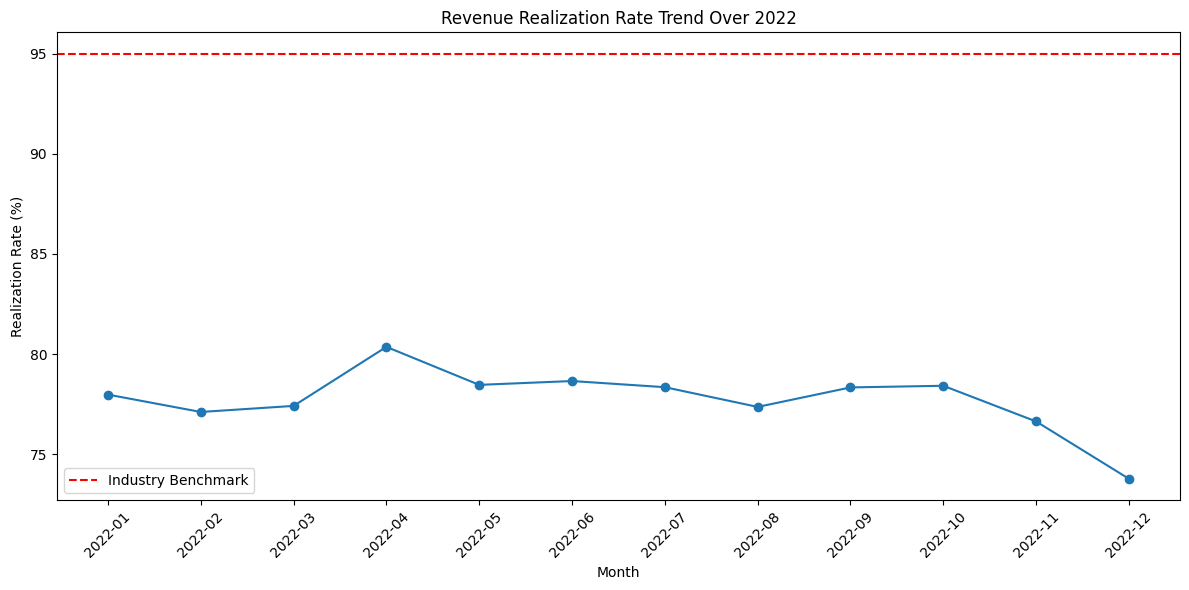

In [85]:
# Monthly trend analysis
df_fin['service_month'] = df_fin['LINE_1ST_EXPNS_DT'].dt.to_period('M')

monthly_trends = df_fin.groupby('service_month').agg({
    'LINE_ALOWD_CHRG_AMT': 'sum',
    'LINE_NCH_PMT_AMT': 'sum',
    'UNDERPAYMENT_AMT': 'sum',
    'ZERO_PAID_FLAG': 'mean'
})

monthly_trends['realization_rate'] = (
    monthly_trends['LINE_NCH_PMT_AMT'] / monthly_trends['LINE_ALOWD_CHRG_AMT']
) * 100

# Plot trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends.index.astype(str), monthly_trends['realization_rate'], marker='o')
plt.title('Revenue Realization Rate Trend Over 2022')
plt.xlabel('Month')
plt.ylabel('Realization Rate (%)')
plt.xticks(rotation=45)
plt.axhline(y=95, color='r', linestyle='--', label='Industry Benchmark')
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
# Create final presentation-ready outputs

# 1. Executive Summary
exec_metrics = pd.DataFrame({
    'Metric': [
        'Total Claims Analyzed',
        'Total Revenue Processed',
        'Revenue Realization Rate',
        'Total Revenue Leakage',
        'Zero-Paid Rate',
        'Partial-Paid Rate',
        'Avg Processing Time',
        'High-Risk Services'
    ],
    'Value': [
        f"{len(df_fin):,}",
        f"${df_fin['LINE_ALOWD_CHRG_AMT'].sum()/1e6:.2f}M",
        f"{100 * df_fin['LINE_NCH_PMT_AMT'].sum() / df_fin['LINE_ALOWD_CHRG_AMT'].sum():.1f}%",
        f"${df_fin['UNDERPAYMENT_AMT'].sum()/1e6:.2f}M",
        f"{df_fin['ZERO_PAID_FLAG'].mean()*100:.1f}%",
        f"{df_fin['PARTIAL_PAID_FLAG'].mean()*100:.1f}%",
        f"{df_fin['PROCESSING_DELAY_DAYS'].mean():.1f} days",
        f"{len(risk_priority)}"
    ]
})

# 2. Top 5 Action Items with $ Impact
top_hcpcs_impact = hcpcs_summary.head(5)[['HCPCS_CD', 'services', 'underpayment_amt', 'realization_rate']]
top_hcpcs_impact['potential_recovery'] = top_hcpcs_impact['underpayment_amt'] * 0.20  # Assume 20% recoverable

# 3. Save all outputs
with pd.ExcelWriter('RCM_Analysis_Final.xlsx', engine='openpyxl') as writer:
    exec_metrics.to_excel(writer, sheet_name='Executive_Summary', index=False)
    top_hcpcs_impact.to_excel(writer, sheet_name='Top_Opportunities', index=False)
    overall_summary.to_excel(writer, sheet_name='Overall_Metrics', index=False)
    hcpcs_summary.head(20).to_excel(writer, sheet_name='HCPCS_Analysis', index=False)
    specialty_summary.to_excel(writer, sheet_name='Specialty_Analysis', index=False)
    leakage_breakdown.to_excel(writer, sheet_name='Leakage_Breakdown', index=False)

print("✓ Final presentation workbook created: RCM_Analysis_Final.xlsx")

✓ Final presentation workbook created: RCM_Analysis_Final.xlsx


In [67]:
hcpcs_variation.to_csv("hcpcs_variation_outliers.csv", index=False)
risk_priority.to_csv("high_risk_services.csv", index=False)

# **Visualizations**

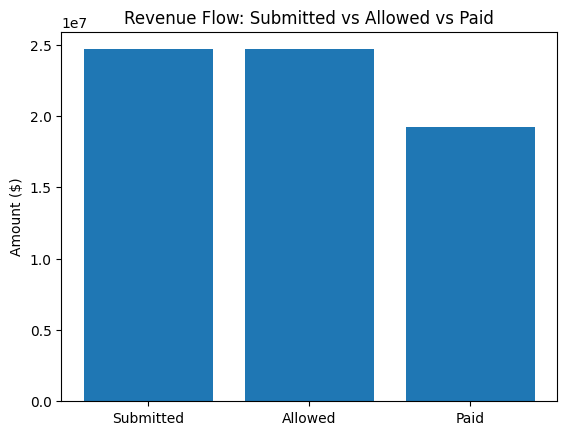

In [68]:
# Revenue Realization Waterfall

import matplotlib.pyplot as plt

labels = ["Submitted", "Allowed", "Paid"]
values = [
    df_fin["LINE_SBMTD_CHRG_AMT"].sum(),
    df_fin["LINE_ALOWD_CHRG_AMT"].sum(),
    df_fin["LINE_NCH_PMT_AMT"].sum()
]

plt.figure()
plt.bar(labels, values)
plt.title("Revenue Flow: Submitted vs Allowed vs Paid")
plt.ylabel("Amount ($)")
plt.show()


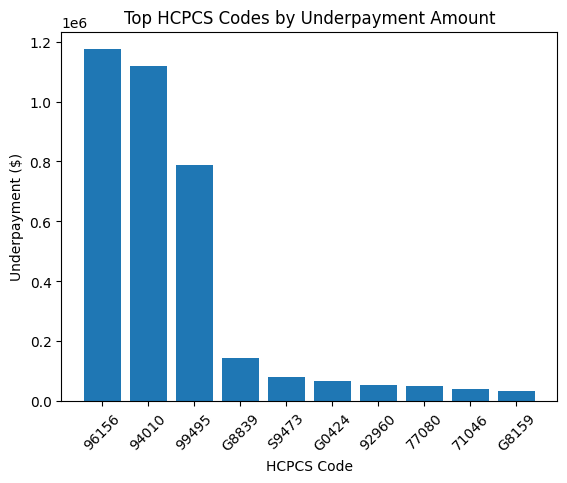

In [69]:
# HCPCS Pareto – Underpayment Drivers

top_hcpcs = hcpcs_summary.head(10)

plt.figure()
plt.bar(top_hcpcs["HCPCS_CD"], top_hcpcs["underpayment_amt"])
plt.title("Top HCPCS Codes by Underpayment Amount")
plt.ylabel("Underpayment ($)")
plt.xlabel("HCPCS Code")
plt.xticks(rotation=45)
plt.show()


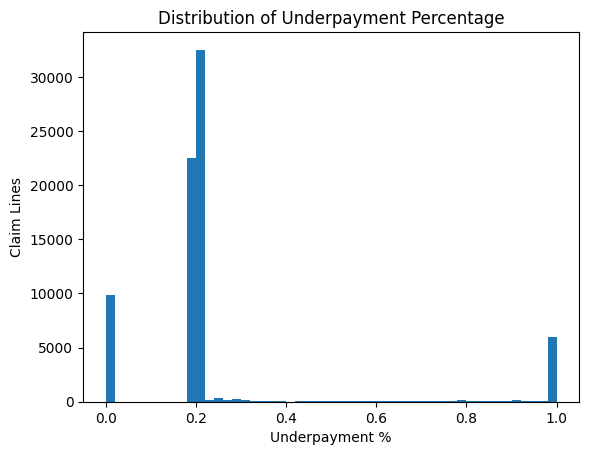

In [70]:
# Underpayment % Distribution

plt.figure()
plt.hist(df_fin["UNDERPAYMENT_PCT"], bins=50)
plt.title("Distribution of Underpayment Percentage")
plt.xlabel("Underpayment %")
plt.ylabel("Claim Lines")
plt.show()


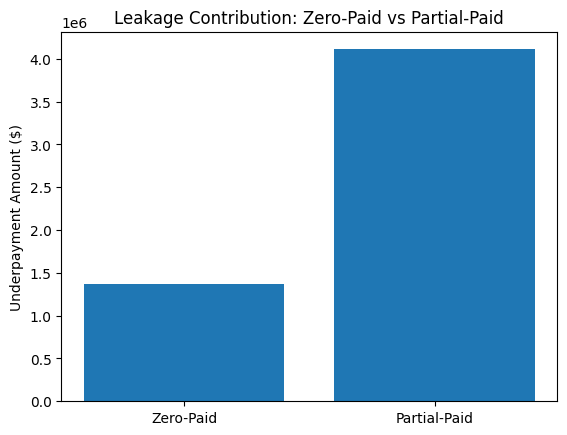

In [71]:
# Zero vs Partial Payment Contribution

labels = leakage_breakdown["Category"]
values = leakage_breakdown["Underpayment Amount"]

plt.figure()
plt.bar(labels, values)
plt.title("Leakage Contribution: Zero-Paid vs Partial-Paid")
plt.ylabel("Underpayment Amount ($)")
plt.show()


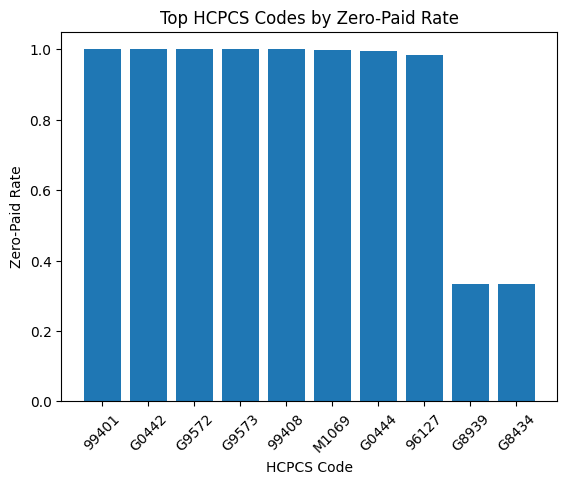

In [72]:
# Denial Proxy Rates by HCPCS

top_denial = hcpcs_denial.sort_values(
    by="zero_paid_rate", ascending=False
).head(10)

plt.figure()
plt.bar(top_denial["HCPCS_CD"], top_denial["zero_paid_rate"])
plt.title("Top HCPCS Codes by Zero-Paid Rate")
plt.ylabel("Zero-Paid Rate")
plt.xlabel("HCPCS Code")
plt.xticks(rotation=45)
plt.show()


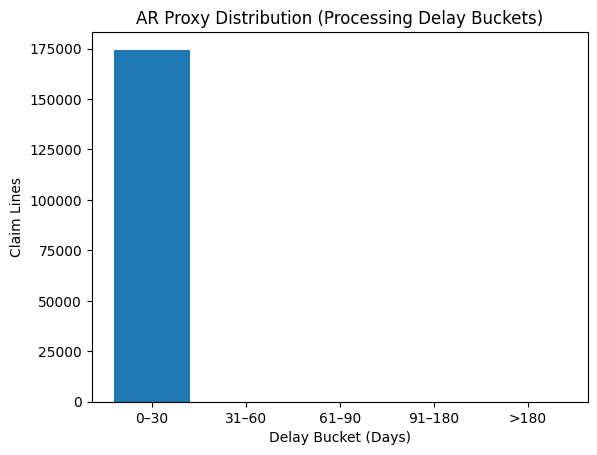

In [73]:
# AR Aging Distribution

bucket_counts = df_delay["AR_BUCKET"].value_counts().sort_index()

plt.figure()
plt.bar(bucket_counts.index.astype(str), bucket_counts.values)
plt.title("AR Proxy Distribution (Processing Delay Buckets)")
plt.xlabel("Delay Bucket (Days)")
plt.ylabel("Claim Lines")
plt.show()


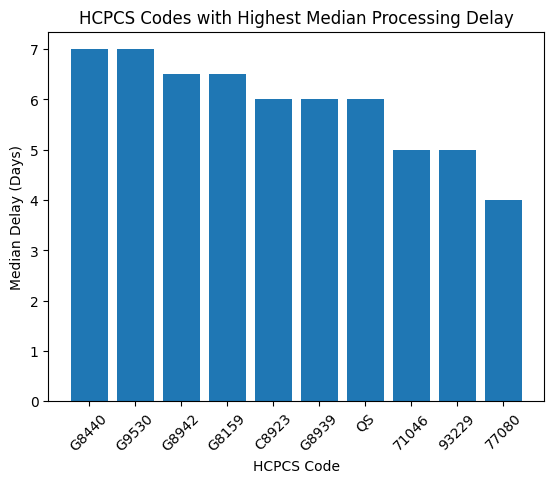

In [74]:
# Median Delay by HCPCS

top_delay = hcpcs_delay.sort_values(
    by="median_delay_days", ascending=False
).head(10)

plt.figure()
plt.bar(top_delay["HCPCS_CD"], top_delay["median_delay_days"])
plt.title("HCPCS Codes with Highest Median Processing Delay")
plt.ylabel("Median Delay (Days)")
plt.xlabel("HCPCS Code")
plt.xticks(rotation=45)
plt.show()


In [75]:
print(hcpcs_variation.shape)
print(hcpcs_variation[["mean_underpay_pct","cv_underpay"]].head())

(36, 11)
   mean_underpay_pct  cv_underpay
0           0.200000     0.975900
1           0.183333     1.062881
2           0.181818     0.331662
3           0.195707     0.939325
4           0.207098     0.893866


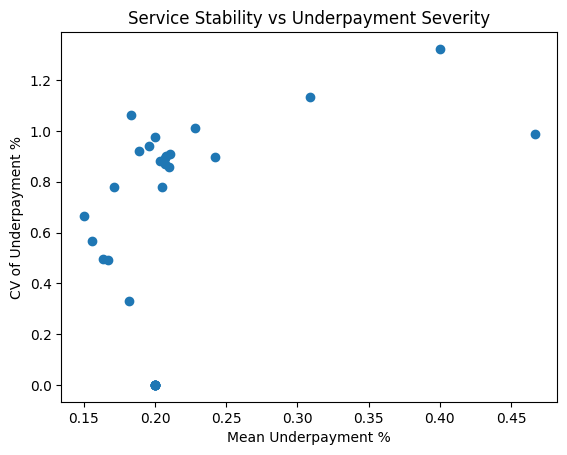

In [76]:
# Stability vs Risk Scatter

plt.figure()
plt.scatter(
    hcpcs_variation["mean_underpay_pct"],
    hcpcs_variation["cv_underpay"]
)

plt.xlabel("Mean Underpayment %")
plt.ylabel("CV of Underpayment %")
plt.title("Service Stability vs Underpayment Severity")

plt.show()


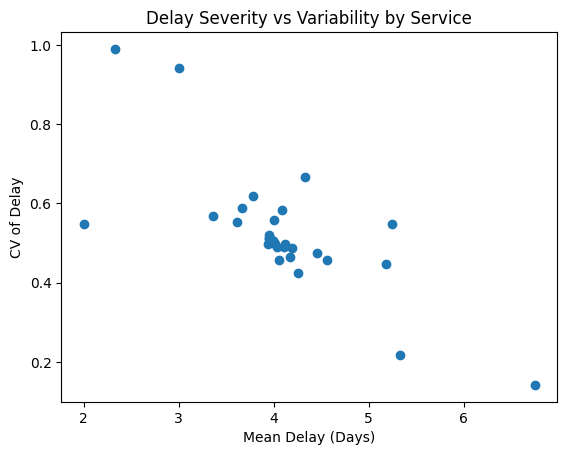

In [77]:
# Delay Variability Scatter

plt.figure()
plt.scatter(
    hcpcs_variation["mean_delay_days"],
    hcpcs_variation["cv_delay"]
)

plt.xlabel("Mean Delay (Days)")
plt.ylabel("CV of Delay")
plt.title("Delay Severity vs Variability by Service")

plt.show()
